## Plot Selected Trajectories 

In this notebook, we generate the plots for the selected trajectories. We will use the `plotly`, `seaborn`, and 
`matplotlib` 
libraries to generate the plots. The plots will be saved in the `plots` directory.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
import datetime
import os
import os.path as osp
import sys
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd
import pytz

from dateutil.relativedelta import relativedelta
from gensim.models import Word2Vec
from openTSNE import TSNE

In [3]:
from argparse import Namespace

In [4]:
os.chdir("..")

In [5]:
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('.'))

In [6]:
import const
from arguments import parse_args
from embed import alignment
from embed.embeddings import Embedding
from utility.utils_data import load_keywords
from utility.utils_misc import project_setup
from utility.utils_time import TimeIterator, get_file_times


In [7]:
args = Namespace(base_year=2023, 
                 batch_size=256, 
                 checkpoint_dir='checkpoints', 
                 data_dir='data', 
                 debug=False, 
                 do_plotly=True, 
                 device='cuda', 
                 do_visual=False, 
                 embedding_dim=50, 
                 epochs=50, embed_dim=100, 
                 graph_backend='networkx', 
                 lr=0.01, model_name='word2vec', 
                 num_workers=16, output_dir='outputs', 
                 save_every=20, save_model=False, 
                 start_year=1985, end_year=2025, 
                 load_from_cache=False, step_size=50, 
                 seed=42, feature_name='title', 
                 tokenization_mode='llm_extracted_keyword', 
                 graphistry_personal_key_id='', 
                 graphistry_personal_key_secret='', 
                 min_occurrences=3)

In [ ]:
keywords = load_keywords(args.data_dir, args.feature_name)

highlighted_words_embed_dict = defaultdict(dict)

# We plot the trajectories of these words over time
highlighted_words = ["artificial intelligence", "machine learning", "deep learning", "natural language "
                                                                                         "processing", "nlp",
                         "optimization",
                         "large language "
                         "models",
                         "llm", "language model", "attention", "neural networks", "transformer", "transformers", "bias",
                         "covid",
                         "covid-19", "sars-cov-2",
                         "quantum computing", "quantum", "gravitational waves", "decision making", "decision"]
nearest_neighbors = set()

iterator = TimeIterator(args.start_year, args.end_year, start_month=1, end_month=1, snapshot_type='yearly')

first_iteration = True

words_current_year = set()
words_previous_year = set()

embed_previous_year = None

# Align all embeddings to this timestamp
base_embed_start_timestamp = datetime.datetime(2023, 1, 1, 0, 0, 0, tzinfo=pytz.utc)

keywords['year'] = keywords['published'].dt.year
keyword_counts_base = keywords[keywords['year'] == args.base_year].explode('keywords').groupby('keywords').size()


In [9]:
if args.model_name == "word2vec":
    base_embed_filename = f"{args.model_name}_{base_embed_start_timestamp.strftime(const.format_string)}-" \
                          f"{(base_embed_start_timestamp + relativedelta(years=1)).strftime(const.format_string)}.model"

    base_embed_filename = f"{args.model_name}_{base_embed_start_timestamp.year}.model"


    base_embed = Word2Vec.load(
        osp.join(args.checkpoint_dir, f"{args.feature_name}_{args.tokenization_mode}", const.WORD2VEC, base_embed_filename))

    base_embed = Embedding(base_embed.wv.vectors, base_embed.wv.index_to_key, normalize=True)

elif args.model_name == "gcn":

    path = osp.join(args.checkpoint_dir, f"{args.feature_name}_{args.tokenization_mode}", args.model_name,
                    f"gcn_embeds_{args.base_year}.pkl")

    with open(path, "rb") as f:
        d = pickle.load(f)

    node_mapping = d['node_mapping']
    embed = d['embed']
    base_embed = Embedding(embed.numpy(), list(node_mapping.keys()), normalize=True)

else:
    raise NotImplementedError

In [10]:
# Filter out words that appear less than `min_occurrences` times
base_embed = base_embed.get_subembed(
    keyword_counts_base[keyword_counts_base >= args.min_occurrences].index.tolist())
print(f"#Words in base embedding: {len(base_embed.iw)}")

valid_words_mask_base = base_embed.m.sum(axis=1) != 0

words_base_embeds = set(np.array(base_embed.iw)[valid_words_mask_base])

#Words in base embedding: 43807


In [11]:
year_to_num_words = {}

for (start, end) in iterator:

    

    if args.model_name == const.WORD2VEC:

        model_path = osp.join(args.checkpoint_dir, f"{args.feature_name}_{args.tokenization_mode}", args.model_name,
                              f"{args.model_name}_{start.year}.model")

        get_file_times(model_path)

        model = Word2Vec.load(model_path)
        embed = Embedding(model.wv.vectors, model.wv.index_to_key, normalize=True)


    elif args.model_name == const.GCN:

        model_path = osp.join(args.checkpoint_dir, f"{args.feature_name}_{args.tokenization_mode}", args.model_name,
                              f"{args.model_name}_{start.year}.pkl")

        with open(model_path, "rb") as f:
            d = pickle.load(f)

        node_mapping = d['node_mapping']
        embed = d['embed']

        embed = Embedding(embed.numpy(), list(node_mapping.keys()), normalize=True)

        get_file_times(model_path)

    else:
        raise NotImplementedError

    keyword_counts_snapshot = keywords[keywords['year'] == args.base_year].explode('keywords').groupby('keywords').size()

    embed = embed.get_subembed(
        keyword_counts_snapshot[keyword_counts_snapshot >= args.min_occurrences].index.tolist())

    year_to_num_words[start] = len(embed.iw)

    print(f"#Words (Year {start.year}): {len(embed.iw)}")

    print(f"Loading model from {model_path} ...", end='\r')

    valid_words_mask_cur_year = embed.m.sum(axis=1) != 0

    words_current_year = set(np.array(embed.iw)[valid_words_mask_cur_year])

    if start.year == args.base_year:
        # base_embedding is the year we want to plot the scatterplot
        aligned_embed = embed


    else:
        aligned_embed = alignment.smart_procrustes_align(base_embed, embed)
        # aligned_embed = procrustes_align(base_embed, embed, words_current_year & words_base_embeds)

    highlighted_words_embed = aligned_embed.get_subembed(highlighted_words)

    for word1 in highlighted_words:
        """
        closest_words_and_similarity:
        [
            (similarity1, word1), # The 1st entry corresponds to word1 itself
            (similarity2, word2), # The 2nd entry is the most similar word to word1
            ...
        ]
        """
        if embed.wi.get(word1) is None:
            highlighted_words_embed_dict[word1][start.year] = None
            continue

        closest_words_and_similarity = embed.closest(word1, n=len(embed.iw))

        print(f"[Year={start.year}] Closest words to '{word1}': "
              f"{', '.join([word for _, word in closest_words_and_similarity[1:6]])}")

        closest_words_ranking = {word2: i for i, (_, word2) in enumerate(closest_words_and_similarity)}

        # Annotate some nodes in the background
        # We only consider the top 5 closest words in each year
        nearest_neighbors.update([word for i, (_, word) in enumerate(closest_words_and_similarity) if (1 <= i <=
                                                                                                       5)])

        if word1 in highlighted_words_embed.wi:
            highlighted_words_embed_dict[word1][start.year] = highlighted_words_embed.m[
                highlighted_words_embed.wi[word1]].astype(np.float32)

        else:
            highlighted_words_embed_dict[word1][start.year] = None

    embed_previous_year = embed
    words_previous_year = words_current_year


File: checkpoints/title_llm_extracted_keyword/word2vec/word2vec_1985.model Creation: 2024-08-24 23:17:34, Last Modified: 2024-08-24 23:17:34
#Words (Year 1985): 620
[Year=1985] Closest words to 'artificial intelligence': part-of-speech tagging, machine learning, machine translation, neural networks, automorphism groups
[Year=1985] Closest words to 'machine learning': natural language processing, quantum field theory, algebraic geometry, neural networks, quantum gravity
[Year=1985] Closest words to 'natural language processing': algebraic geometry, quantum field theory, lattice qcd, quantum mechanics, general relativity
[Year=1985] Closest words to 'optimization': quantum field theory, quantum gravity, hamiltonian systems, orthogonal polynomials, natural language processing
[Year=1985] Closest words to 'neural networks': natural language processing, algebraic geometry, machine learning, quantum field theory, lattice qcd
[Year=1985] Closest words to 'quantum': lattice qcd, algebraic geom

In [12]:
np.mean(list(year_to_num_words.values()))

8943.870967741936

In [13]:
visualization_model = TSNE(initialization="pca", n_components=2, perplexity=30, metric="cosine", n_iter=300,
                           verbose=True)
# valid_words_mask_base should be all `True`

embedding_train = visualization_model.fit(base_embed.m[valid_words_mask_base])

# Convert embedding_train and words list into a DataFrame
background_df = pd.DataFrame(embedding_train, columns=['x', 'y'])
background_df['word'] = np.array(base_embed.iw)[valid_words_mask_base]



trajectories = []
for word in highlighted_words_embed_dict:
    years = list(highlighted_words_embed_dict[word].keys())

    embeds, valid_embed_years = [], []
    for year in years:
        # Skip the years in which the keyword does not appear
        if highlighted_words_embed_dict[word][year] is None:
            continue
        embeds.append(highlighted_words_embed_dict[word][year])
        valid_embed_years.append(year)

    if len(embeds) == 0:
        continue

    # Transform embeddings into 2D coordinates
    embeds = np.array(embeds)
    embeds = embedding_train.transform(embeds)

    prev_coords = None
    for idx_year, year in enumerate(valid_embed_years):
        trajectories.append({
            "word": word,
            "year": year,
            "x": embeds[idx_year, 0],
            "y": embeds[idx_year, 1]
        })

trajectories_df = pd.DataFrame(trajectories)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='cosine', n_iter=300, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 38.40 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.66 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.09 seconds
===> Running optimization with exaggeration=12.00, lr=3650.58 for 250 iterations...
Iteration   50, KL divergence 6.0611, 50 iterations in 2.5081 sec
Iteration  100, KL divergence 6.1661, 50 iterations in 2.3892 sec
Iteration  150, KL divergence 6.1660, 50 iterations in 2.3971 sec
Iteration  200, KL divergence 6.1571, 50 iterations in 2.3774 sec
Iteration  250, KL divergence 6.1574, 50 iterations in 2.3983 sec
   --> Time elapsed: 12.07 seconds
===> Running optimization with exaggeration=

In [14]:
trajectories_df

,word,year,x,y
0,artificial intelligence,1985,19.533570,-43.223929
1,artificial intelligence,1998,22.832544,12.019982
2,artificial intelligence,1999,22.816544,12.714821
3,artificial intelligence,2000,22.866574,12.279292
4,artificial intelligence,2003,17.319771,-41.271219
...,...,...,...,...
350,decision making,2021,-26.791001,-20.039310
351,decision making,2022,-20.098961,-23.913407
352,decision making,2023,-26.896046,-20.789320
353,decision making,2024,-26.850166,-20.660094


In [15]:
path = 'outputs/keyword_trajectories/trajectories_covid.xlsx'


nearest_neighbors = {'age-specific',
 'bots',
 'brazil',
 'compartmental models',
 'covid-19 pandemic',
 'epidemic model',
 'europe',
 'follow-up analysis',
 'hospitalization',
 'impact assessment',
 'india',
 'infection',
 'infections',
 'italy',
 'lockdown measures',
 'lockdowns',
 'monkeypox',
 'mutations',
 'quarantine',
 'sars-cov-2',
 'temporal trends',
 'transmission dynamics',
 'treatment',
 'tuberculosis',
 'vaccination',
 'vaccine hesitancy',
 'viral dynamics',
 'wastewater'}

# Only display nearest neighbors in the background
background_mask_covid = background_df.word.isin(nearest_neighbors)
background_df_covid = background_df[background_mask_covid].reset_index(drop=True).sort_values(['x'])

if not os.path.exists(path):
    with pd.ExcelWriter(path) as writer:
        background_df_covid.to_excel(writer, sheet_name="background", index=False)
        trajectories_df.to_excel(writer, sheet_name="trajectories", index=False)

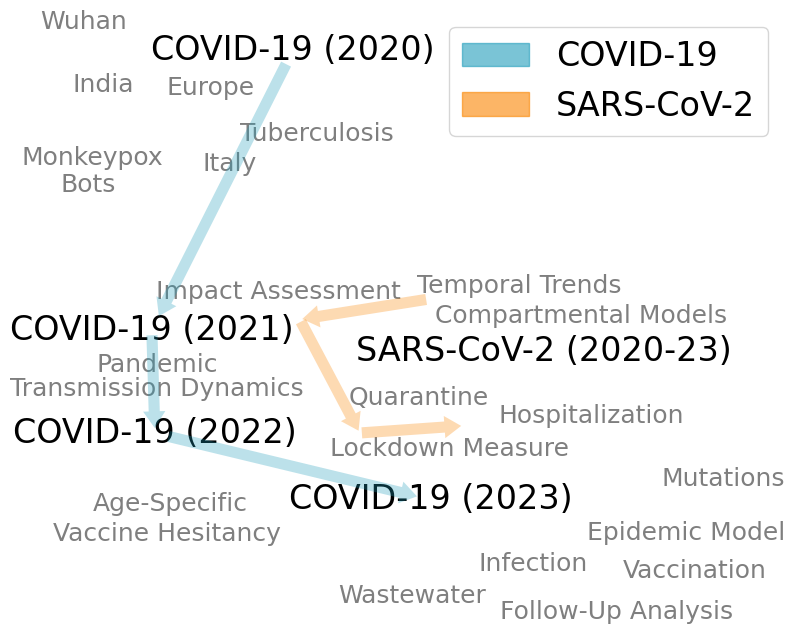

In [70]:
from adjustText import adjust_text

background_df_covid = pd.read_excel(path, sheet_name="background")
trajectories_df_covid = pd.read_excel(path, sheet_name="trajectories")

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(background_df_covid['x'], background_df_covid['y'], alpha=0.0)


adjustable_texts = []
for index, row in background_df_covid.iterrows():
    
    adjustable_texts.append(plt.text(row['x'], row['y'], row['word'], fontsize=18, ha='center', va='center', alpha=0.5))


# Turn off the x and y labels, axis, and ticks
plt.xlabel('')
plt.ylabel('')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
for direction in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[direction].set_visible(False)  # Hide top spine


# Initialize previous coordinates
prev_x, prev_y = None, None
FONTSIZE=24
ARROWHEADWIDTH = 16

# Plot arrows for the trajectories
for word in {"COVID-19"}:
    traj = trajectories_df_covid[trajectories_df_covid['word'] == word]
    traj = traj.sort_values(['year']).reset_index(drop=True)

    for index, row in traj.iterrows():
        
        
        adjustable_texts.append(plt.text(row['x'], row['y'], f"{row['word']} ({row['year']})", fontsize=FONTSIZE, ha='center', va='center', alpha=1.0))

        """
        if prev_x is not None and prev_y is not None:
            # Plot an arrow from (prev_x, prev_y) to (row['x'], row['y'])
            plt.annotate('', xy=(row['x'], row['y']), xytext=(prev_x, prev_y),
                         arrowprops=dict(facecolor='#219ebc', shrink=0.07, alpha=0.3, width=8, headwidth=12, edgecolor='none'))
        """

        # Update prev_x and prev_y to the current point's coordinates
        prev_x = row['x']
        prev_y = row['y']

prev_x, prev_y = None, None
for word in {"SARS-CoV-2"}:
    traj = trajectories_df_covid[trajectories_df_covid['word'] == word]
    traj = traj.sort_values(['year']).reset_index(drop=True)

    for index, row in traj.iterrows():
        
        if prev_x is not None and prev_y is not None:
            # Plot an arrow from (prev_x, prev_y) to (row['x'], row['y'])
            plt.annotate('', xy=(row['x'], row['y']), xytext=(prev_x, prev_y),
                         arrowprops=dict(facecolor='#fb8500', shrink=0.02, alpha=0.3, width=8, headwidth=ARROWHEADWIDTH, edgecolor='none'))
        
        
        # Update prev_x and prev_y to the current point's coordinates
        prev_x = row['x']
        prev_y = row['y']
    
    adjustable_texts.append(plt.text(-18.4751495, 18.36082324, f"{row['word']} (2020-23)", fontsize=FONTSIZE, ha='center', va='center'))


# Add legend
plt.legend(handles=[
    mpatches.FancyArrowPatch((0, 0), (0.5, 0), color='#219ebc', label='COVID-19', alpha=0.6), 
    mpatches.FancyArrowPatch((0, 0), (0.5, 0), color='#fb8500', label='SARS-CoV-2', alpha=0.6)
], loc='upper right', fontsize=FONTSIZE, frameon=True)


# Adjust text to avoid overlap
adjusted_texts = adjust_text(adjustable_texts,  
            autoalign='xy', only_move={'points':'xy', 'text':'xy'}, force_text=(0.1, 0.1))

prev_x, prev_y = None, None
for new_text in adjusted_texts[0]:
    if new_text._text.startswith("COVID-19"):
        if prev_x is not None and prev_y is not None:
            plt.annotate('', xy=(new_text._x, new_text._y), xytext=(prev_x, prev_y),
                             arrowprops=dict(facecolor='#219ebc', shrink=0.05, alpha=0.3, width=8, headwidth=ARROWHEADWIDTH, edgecolor='none'))
        prev_x, prev_y = new_text._x, new_text._y


plt.savefig("outputs/keyword_trajectories/trajectories_covid.pdf", dpi=300)




In [45]:
result[0][-2].__dict__

{'_stale': False,
 'stale_callback': <function matplotlib.artist._stale_axes_callback(self, val)>,
 '_axes': <Axes: >,
 'figure': <Figure size 1000x800 with 1 Axes>,
 '_transform': <matplotlib.transforms.CompositeGenericTransform at 0x3b8641910>,
 '_transformSet': True,
 '_visible': True,
 '_animated': False,
 '_alpha': 1.0,
 'clipbox': <matplotlib.transforms.TransformedBbox at 0x3b8893e90>,
 '_clippath': None,
 '_clipon': False,
 '_label': '',
 '_picker': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x3b888f990>,
 '_remove_method': <function list.remove(value, /)>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_x': -18.0651781515388,
 '_y': 17.36908039307429,
 '_text': 'COVID-19 (2023)',
 '_color': 'black',
 '_fontproperties': <matplotlib.font_manager.FontProperties at 0x3b8893190>,
 '_usetex': False,
 '_

## Plot using plotly

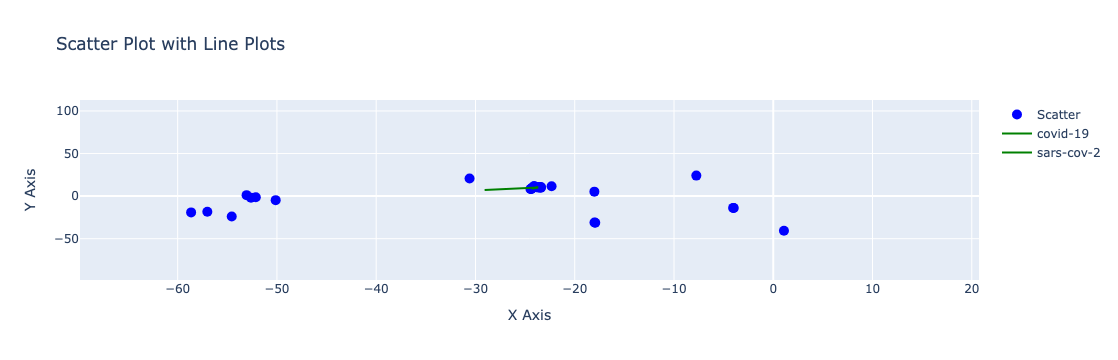

In [40]:
import plotly.graph_objs as go
import plotly.express as px

scatter = go.Scatter(
    x=background_df_covid['x'].values,
    y=background_df_covid['y'].values,
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='Scatter',
    text=background_df_covid['word'],  # Add the words as hover text
    hoverinfo='text'  # Display only the hover text
)

plotly_trajectories = []

for word in highlighted_words:

    traj = trajectories_df[trajectories_df['word'] == word].reset_index(drop=True)

    line = go.Scatter(
        x=traj['x'],
        y=traj['y'],
        mode='lines',
        line=dict(color='green'),
        name=word,
        text=[f'{word} ({year})' for year in traj['year']],
        hoverinfo="text"
    )
    plotly_trajectories += [line]

# Combine the scatter plot and line plots into a single figure
fig = go.Figure(data=[scatter] + plotly_trajectories)

# Update layout for better visibility
fig.update_layout(
    title="Scatter Plot with Line Plots",
    xaxis_title="X Axis",
    yaxis_title="Y Axis"
)

fig.show()

In [172]:
trajectories_df_ai = trajectories_df[trajectories_df['word'].isin({'large language models', 'artificial intelligence'})].reset_index(drop=True)
trajectories_df_ai

,word,year,x,y
0,artificial intelligence,1985,12.275091,-43.687987
1,artificial intelligence,1998,19.651507,-9.971300
2,artificial intelligence,1999,17.351965,12.011625
3,artificial intelligence,2000,17.301506,11.854000
4,artificial intelligence,2003,12.339240,-41.348265
5,artificial intelligence,2004,-22.630082,34.974616
6,artificial intelligence,2006,12.031985,-41.041040
7,artificial intelligence,2007,10.551995,-38.689850
8,artificial intelligence,2008,9.687175,-39.444217
9,artificial intelligence,2009,9.197545,-5.722597


In [220]:
path = 'outputs/visual/trajectories_ai.xlsx'

# Only display nearest neighbors in the background
background_mask_ai = background_df.word.isin(nearest_neighbors)
background_df_ai = background_df[background_mask_ai].reset_index(drop=True).sort_values(['x'])

if True: #not os.path.exists(path):
    with pd.ExcelWriter(path) as writer:
        background_df_ai.to_excel(writer, sheet_name="background", index=False)
        trajectories_df_ai.to_excel(writer, sheet_name="trajectories", index=False)

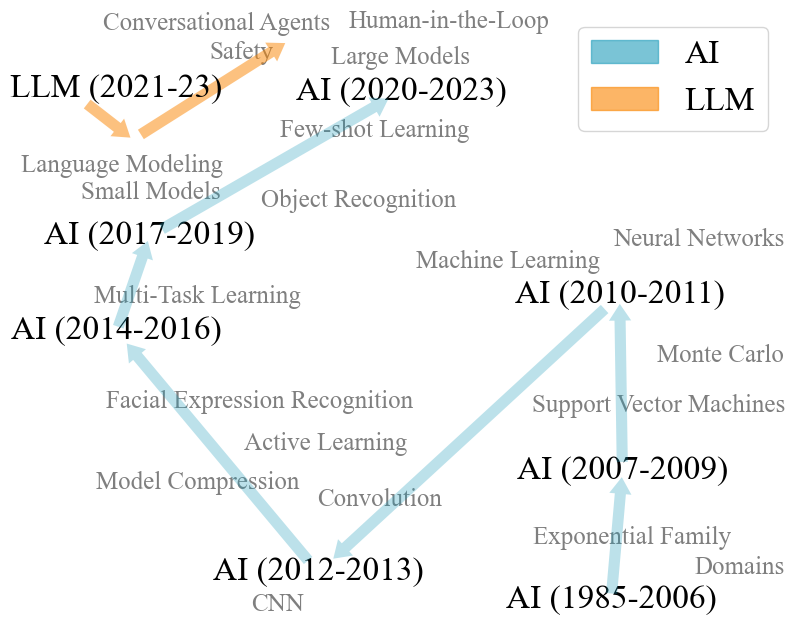

In [125]:
path = 'outputs/keyword_trajectories/trajectories_ai.xlsx'

from adjustText import adjust_text

background_df_ai = pd.read_excel(path, sheet_name="background")
trajectories_df_ai = pd.read_excel(path, sheet_name="trajectories")

nearest_neighbors = {
    "operatorator algebras",
    "domains",
    "family",
    "support vector machines",
    "monte carlo",
    "neural networks",
    "machine learning",
    "active learning",
    "multi-task learning",
    "facial expression recognition",
    "model compression",
    "convolution",
    "convolutional neural network",
    "language modeling",
    "nlp",
    "conversational agents",
    "human-in-the-loop",
    "small models",
    "object recognition"
}

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(background_df_ai['x'], background_df_ai['y'], alpha=0.0)


adjusted_texts = []
for index, row in background_df_ai.iterrows():
    adjusted_texts.append(plt.text(row['x'], row['y'], row['word'], fontsize=18, ha='center', va='center', alpha=0.5))


# Turn off the x and y labels, axis, and ticks
plt.xlabel('')
plt.ylabel('')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
for direction in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[direction].set_visible(False)  # Hide top spine


# Initialize previous coordinates
prev_x, prev_y = None, None

# Plot arrows for the trajectories
for word in {"AI"}:
    traj = trajectories_df_ai[trajectories_df_ai['word'] == word]
    # traj = traj.sort_values(['year']).reset_index(drop=True)

    for index, row in traj.iterrows():
        adjusted_texts.append(plt.text(row['x'], row['y'], f"{row['word']} ({row['year']})", fontsize=FONTSIZE, ha='center', va='center', alpha=1.0))
        # if prev_x is not None and prev_y is not None:
        #     # Plot an arrow from (prev_x, prev_y) to (row['x'], row['y'])
        #     plt.annotate('', xy=(row['x'], row['y']), xytext=(prev_x, prev_y),
        #                  arrowprops=dict(facecolor='#219ebc', shrink=0.07, alpha=0.5, width=3, headwidth=12, edgecolor='none'))
        

        # Update prev_x and prev_y to the current point's coordinates
        prev_x = row['x']
        prev_y = row['y']

prev_x, prev_y = None, None

for word in {"LLM"}:
    traj = trajectories_df_ai[trajectories_df_ai['word'] == word]
    traj = traj.sort_values(['year']).reset_index(drop=True)

    for index, row in traj.iterrows():
        # adjusted_texts.append(plt.text(row['x'], row['y'], f"{row['word']} ({row['year']})", fontsize=FONTSIZE, ha='center', va='center', alpha=1.0))
        if prev_x is not None and prev_y is not None:
            
            # Plot an arrow from (prev_x, prev_y) to (row['x'], row['y'])
            plt.annotate('', xy=(row['x'], row['y']), xytext=(prev_x, prev_y),
                         arrowprops=dict(facecolor='#fb8500', shrink=0.05, alpha=0.5, width=8, headwidth=ARROWHEADWIDTH, edgecolor='none'))
        
        # Update prev_x and prev_y to the current point's coordinates
        prev_x = row['x']
        prev_y = row['y']
    
    adjusted_texts.append(plt.text(-37.4,37.3, f"{row['word']} (2021-23)", fontsize=FONTSIZE, ha='center', va='center'))


# Create legend handles and add legend
plt.legend(handles=[
    mpatches.FancyArrowPatch((0, 0), (1, 0), color='#219ebc', label='AI', alpha=0.6), 
    mpatches.FancyArrowPatch((0, 0), (1, 0), color='#fb8500', label='LLM', alpha=0.6)
], loc='upper right', fontsize=FONTSIZE, frameon=True)

# Adjust text to avoid overlap
adjusted_texts = adjust_text(adjusted_texts, autoalign='xy', only_move={'points':'xy', 'text':'xy'}, force_text=(0.05, 0.05))


prev_x, prev_y = None, None
for new_text in adjusted_texts[0]:
    if new_text._text.startswith("AI"):
        if prev_x is not None and prev_y is not None:
            plt.annotate('', xy=(new_text._x, new_text._y), xytext=(prev_x, prev_y),
                             arrowprops=dict(facecolor='#219ebc', shrink=0.05, alpha=0.3, width=8, headwidth=ARROWHEADWIDTH, edgecolor='none'))
        prev_x, prev_y = new_text._x, new_text._y



plt.savefig("outputs/keyword_trajectories/trajectories_ai.pdf", dpi=300)

In [111]:
import plotly.graph_objs as go
import plotly.express as px

scatter = go.Scatter(
    x=background_df_masked['x'].values,
    y=background_df_masked['y'].values,
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='Scatter',
    text=background_df_masked['word'],  # Add the words as hover text
    hoverinfo='text'  # Display only the hover text
)

plotly_trajectories = []

for word in highlighted_words:

    traj = trajectories_df[trajectories_df['word'] == word].reset_index(drop=True)

    line = go.Scatter(
        x=traj['x'],
        y=traj['y'],
        mode='lines',
        line=dict(color='green'),
        name=word,
        text=[f'{word} ({year})' for year in traj['year']],
        hoverinfo="text"
    )
    plotly_trajectories += [line]

# Combine the scatter plot and line plots into a single figure
fig = go.Figure(data=[scatter] + plotly_trajectories)

# Update layout for better visibility
fig.update_layout(
    title="Scatter Plot with Line Plots",
    xaxis_title="X Axis",
    yaxis_title="Y Axis"
)

fig.show()

NameError: name 'background_df_masked' is not defined